In [ ]:
#Install required libraries

import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en

#!pip install gensim
!pip install gensim==3.8.3
!pip install pyLDAvis
!pip install pyLDAvis.gensim_models
!pip install spacy
!pip install en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-03-20 06:48:00.911076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 06:48:01.065648: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-20 06:48:01.849736: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LI

In [ ]:
###Topic Modelling
#Import required libraries

import pandas as pd
import numpy as np
import re
import warnings

#NLTK and Spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
import spacy
from pprint import pprint
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

#Gensim 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# pyLDAVIS for drawing the charts
import pyLDAvis
import pyLDAvis.gensim_models  
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


warnings.filterwarnings(action = 'ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#Import the dataset containing Short Text Tweets

# Import Dataset
df = pd.read_csv('tweets.csv')
print(df['username'].unique())
df.head()

['realJackEason' 'ManojKu40226010' 'TansyWatts' ... 'phenocine' 'SatikVFX'
 'Habib36531103']


,_id,username,text,qScore,nScore
0,1621600585291014145,realJackEason,@pansexualflower Criterion certainly have US r...,0.613271,2.934114
1,1621600584360153088,ManojKu40226010,🇨🇳 🇺🇸 #China\n#Chinese #Foreign #Ministry said...,0.446642,-2.994406
2,1621600585358233600,TansyWatts,“As they began to understand the children’s op...,0.609156,1.772004
3,1621600585391783943,Green_Man1984,Excess Deaths Skyrocket Again In England And W...,0.608929,-1.639187
4,1621600586020933632,bruis3pristin3,"@altgirlalterego scotland, seychelles, syria, ...",0.608089,-0.254614


In [ ]:
#Calculate Maximum and Minimum Length Tweets 

df['text_len'] = df['text'].str.len()
df_sorted = df.sort_values(by='text_len', ascending=False)

print(df_sorted[['text', 'text_len']].head())


print(df_sorted[['text', 'text_len']].tail())

                                                   text  text_len
1749  @MasalaFry69 @JackieKane @cool_grandad @nickys...       926
2673  @DocDeezWhat @Wanderinglord @VinceGottalotta @...       894
6813  @PPPTCE @MAGA_Translator @Julie_NoNumbers @kev...       881
9750  @peregrinepfp @gillren96 @VtTbQW9s3xjPOow @elk...       803
7932  @EricRaThorn @Flipper61294 @P3ng1z @BetalJuice...       794
                        text  text_len
453   Awww rip Janice  #TOTP        22
6636   1st start Josh 👏 #18s        21
570    Yet another dead cat.        21
4648      hate new york istg        18
3214      Aww fanks four dat        18


In [ ]:
#Regular expression to remove email id and hyperlinks

# Convert to list
data = df['text'].tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sentence) for sentence in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sentence) for sentence in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sentence) for sentence in data]

#Remove Hyperlinks from the data
data = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', sentence) for sentence in data]

#Remove Emojis from data
emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
data = [re.sub(emoji, '', text) for text in data]

print(data)

['Criterion certainly have US rights to the restoration but very unlikely they have any claim to UK UHD rights alone. This seems more like a cost analysis decision by the BFI. Or else they determined the new restoration doesnt merit 4K for home release, which would be odd.', '  #China #Chinese #Foreign #Ministry said that this is a weather balloon that had deviated from its course. The #Pentagon said that it is not a military threat. #Poland #Canada #India #Australia #London #kyiv #Dubai #Israel #NewyorkCity #Toronto #iran ', '“As they began to understand the children’s operational schemes, they were more purposeful in their visits and what they collected and offered to the children.” Love this child-led influence ', 'Excess Deaths Skyrocket Again In England And Wales 15,804 deaths, and 1,568 excess deaths were registered in England and Wales in the week ending January 20th 2023 which was 11% above the five-year average. What is happening?  ', 'scotland, seychelles, syria, south africa

In [ ]:
#Tokenize the sentence and remove the punctuations

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  

data_words = list(sent_to_words(data))

print(data_words[:2])

[['criterion', 'certainly', 'have', 'us', 'rights', 'to', 'the', 'restoration', 'but', 'very', 'unlikely', 'they', 'have', 'any', 'claim', 'to', 'uk', 'uhd', 'rights', 'alone', 'this', 'seems', 'more', 'like', 'cost', 'analysis', 'decision', 'by', 'the', 'bfi', 'or', 'else', 'they', 'determined', 'the', 'new', 'restoration', 'doesnt', 'merit', 'for', 'home', 'release', 'which', 'would', 'be', 'odd'], ['china', 'chinese', 'foreign', 'ministry', 'said', 'that', 'this', 'is', 'weather', 'balloon', 'that', 'had', 'deviated', 'from', 'its', 'course', 'the', 'pentagon', 'said', 'that', 'it', 'is', 'not', 'military', 'threat', 'poland', 'canada', 'india', 'australia', 'london', 'kyiv', 'dubai', 'israel', 'newyorkcity', 'toronto', 'iran']]


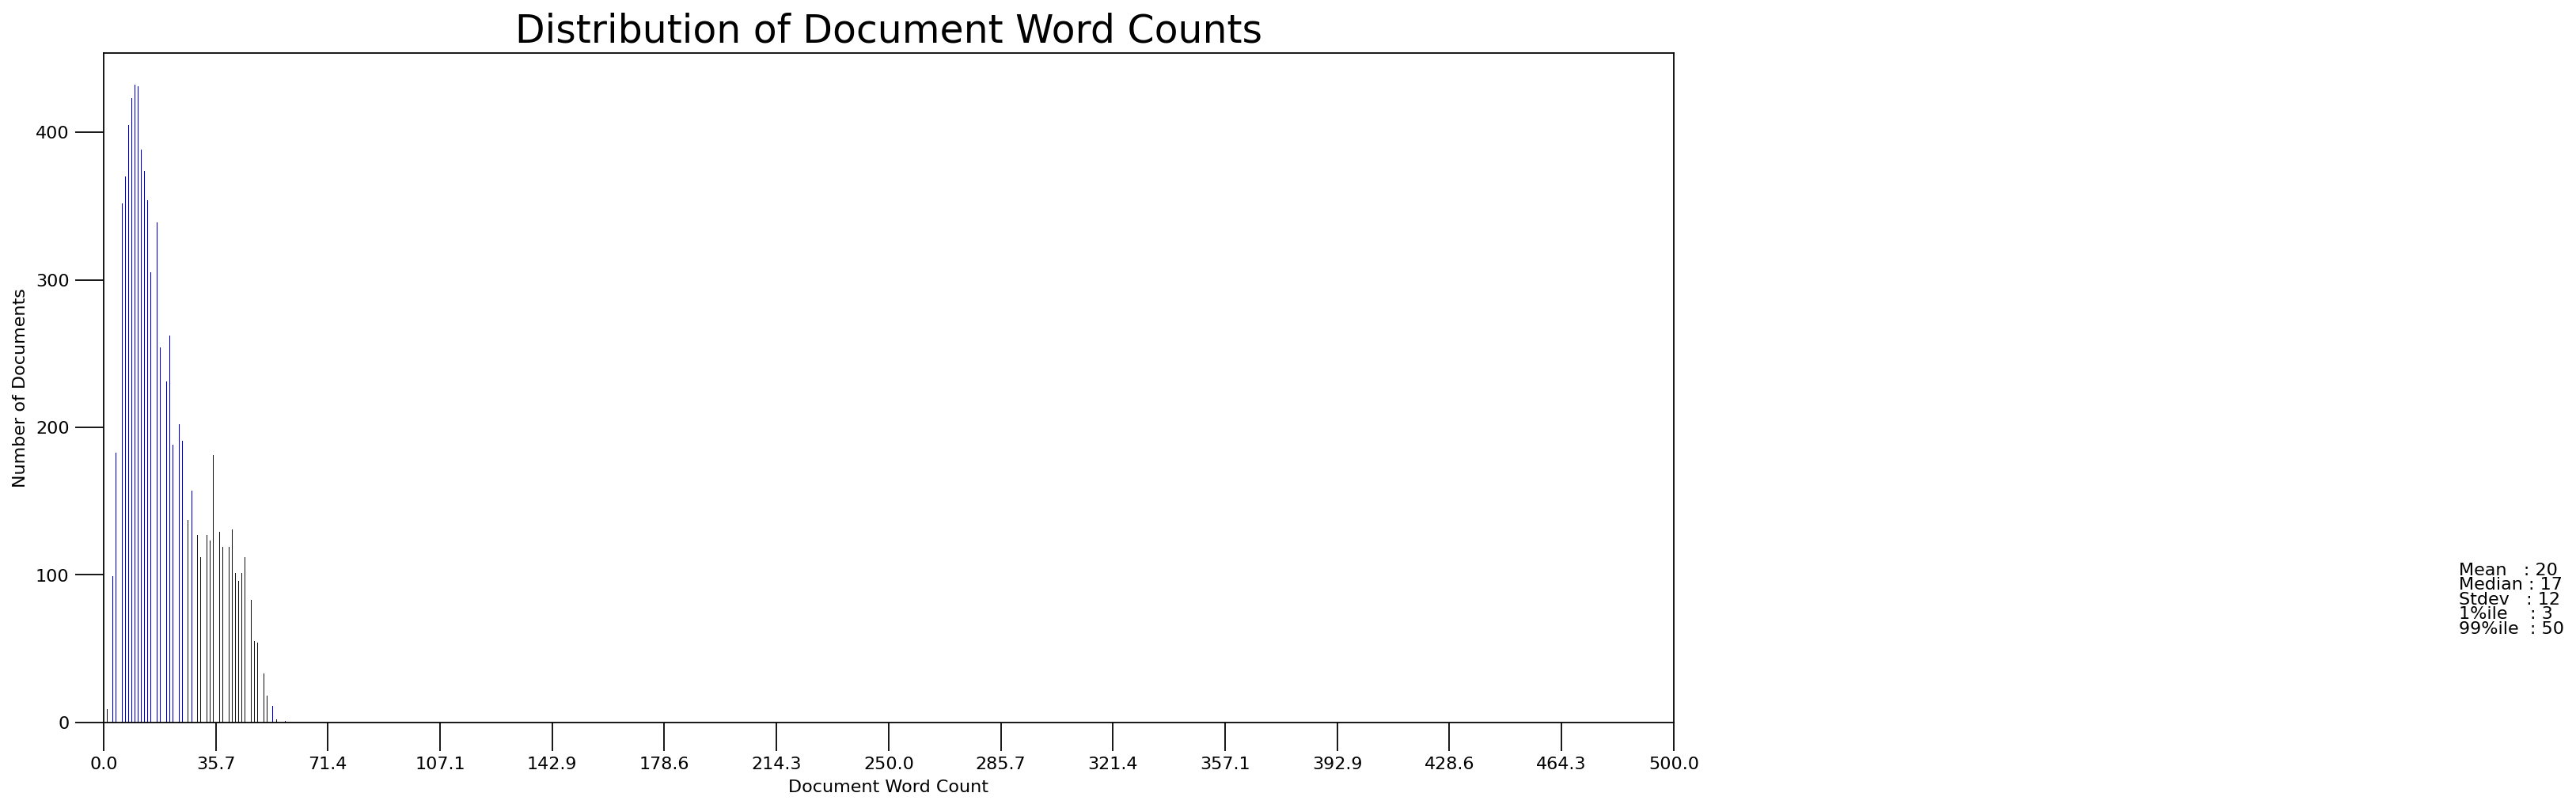

In [ ]:
#Distribution of Document word count ---> check how to do this

doc_word_distribution = [len(d) for d in data_words]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_word_distribution, bins = 300, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_word_distribution))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_word_distribution))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_word_distribution))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_word_distribution, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_word_distribution, q=0.99))))

plt.gca().set(xlim=(0, 500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,500,15))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()


In [ ]:
# Build the bigram
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)


In [ ]:
# Remove stopwords and make Bigrams

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
stop_words = stopwords.words('english')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
import spacy
nlp = spacy.load("en_core_web_sm")
print(nlp)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

[['criterion', 'certainly', 'right', 'restoration', 'unlikely', 'claim', 'right', 'alone', 'seem', 'cost', 'analysis', 'decision', 'bfi', 'else', 'determine', 'new', 'restoration', 'merit', 'home', 'release', 'odd'], ['say', 'weather', 'deviate', 'course', 'say', 'military', 'dubai']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 2), (17, 1), (18, 1)]]


In [ ]:
#Term frequency of words in corpus

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('alone', 1),
  ('analysis', 1),
  ('bfi', 1),
  ('certainly', 1),
  ('claim', 1),
  ('cost', 1),
  ('criterion', 1),
  ('decision', 1),
  ('determine', 1),
  ('else', 1),
  ('home', 1),
  ('merit', 1),
  ('new', 1),
  ('odd', 1),
  ('release', 1),
  ('restoration', 2),
  ('right', 2),
  ('seem', 1),
  ('unlikely', 1)],
 [('course', 1),
  ('deviate', 1),
  ('dubai', 1),
  ('military', 1),
  ('say', 2),
  ('weather', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.031*"change" + 0.029*"consider" + 0.025*"guy" + 0.023*"force" + 0.019*"fan" + 0.018*"school" + 0.018*"worker" + 0.018*"law" + 0.015*"sound" + 0.014*"number"'), (1, '0.028*"tory" + 0.024*"great" + 0.024*"pay" + 0.023*"vote" + 0.023*"even" + 0.019*"watch" + 0.018*"last" + 0.017*"s" + 0.015*"find" + 0.014*"start"'), (2, '0.057*"labour" + 0.034*"show" + 0.024*"government" + 0.018*"part" + 0.018*"happen" + 0.017*"plan" + 0.016*"war" + 0.014*"scotland" + 0.014*"price" + 0.014*"ask"'), (3, '0.028*"go" + 0.025*"get" + 0.024*"see" + 0.021*"people" + 0.019*"make" + 0.019*"good" + 0.018*"think" + 0.018*"conservative" + 0.017*"say" + 0.015*"time"'), (4, '0.052*"want" + 0.051*"new" + 0.036*"right" + 0.029*"leave" + 0.016*"boris_johnson" + 0.016*"state" + 0.015*"talk" + 0.014*"hard" + 0.013*"home" + 0.012*"cost"'), (5, '0.039*"day" + 0.038*"work" + 0.031*"use" + 0.027*"play" + 0.016*"m" + 0.014*"news" + 0.014*"party" + 0.014*"amp" + 0.013*"reason" + 0.013*"today"'), (6, '0.035*"support" + 0.

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




Perplexity:  -9.841432568368308

Coherence Score:  0.3917486846242013


In [ ]:
#Hyperparameter Tuning 

#1. Number of Topics (K)
#2. Dirichlet hyperparameter alpha: Document-Topic Density
#3. Dirichlet hyperparameter beta: Word-Topic Density

In [ ]:
### Define the function

def compute_coherence_perplexity_values(dictionary, corpus, texts, num_topics=20):
    coherence_values = []
    perplexity_values = []
       
    model_list = []
    for num_of_topics in range(5,num_topics,1):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(lda_model.log_perplexity(corpus))
          
    return model_list, coherence_values, perplexity_values


In [ ]:
# Can take a long time to run.
model_list, coherence_values, perplexity_values = compute_coherence_perplexity_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, num_topics=25)

In [ ]:
n = np.arange(5,25)
dict_coherence_perplexity = {'Num_Topics':n, "Coherence_Score": coherence_values, "Perplexity_Score": perplexity_values}
#print(dict_coherence_perplexity)
df_coherence_perplexity = pd.DataFrame(dict_coherence_perplexity)
print(df_coherence_perplexity)

    Num_Topics  Coherence_Score  Perplexity_Score
0            5         0.420570         -9.002910
1            6         0.328529         -9.097890
2            7         0.311653         -9.202023
3            8         0.315728         -9.341356
4            9         0.375427         -9.546789
5           10         0.391749         -9.841433
6           11         0.389244        -10.287949
7           12         0.369380        -10.986631
8           13         0.394932        -12.073935
9           14         0.403289        -13.678572
10          15         0.344959        -15.659646
11          16         0.407660        -17.405283
12          17         0.428994        -18.525367
13          18         0.393466        -19.155573
14          19         0.413801        -19.775237
15          20         0.413637        -20.404915
16          21         0.418189        -21.021830
17          22         0.418525        -21.701626
18          23         0.423241        -22.302286


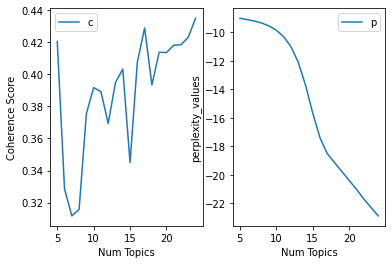

In [ ]:
# Plot Graph of Number of Topics vs Coherence Score
limit=25; start=5; step=1;
plt.subplot(1, 2, 1)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence"), loc='best')
#plt.show()


# Plot Graph of Number of Topics vs Perplexity Score
limit=25; start=5; step=1;
plt.subplot(1, 2, 2)
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("perplexity_values")
plt.legend(("perplexity"), loc='best')
plt.show()



In [ ]:
# Select the Best model 

optimal_model =  model_list[12]
print(optimal_model)
model_topics = optimal_model.show_topics(formatted=False)

# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




LdaModel(num_terms=12816, num_topics=17, decay=0.5, chunksize=100)

Perplexity:  -18.52536654757798

Coherence Score:  0.42899429232853675


In [ ]:
print("Top 10 Keywords in the Topics:")
pprint(optimal_model.print_topics(num_words=10))

Top 10 Keywords in the Topics:
[(0,
  '0.142*"go" + 0.123*"see" + 0.076*"time" + 0.068*"well" + 0.054*"back" + '
  '0.042*"never" + 0.040*"way" + 0.035*"thing" + 0.035*"first" + '
  '0.027*"point"'),
 (1,
  '0.130*"get" + 0.063*"tory" + 0.053*"pay" + 0.051*"vote" + 0.039*"s" + '
  '0.038*"stop" + 0.030*"much" + 0.023*"hear" + 0.023*"care" + 0.023*"put"'),
 (2,
  '0.132*"live" + 0.107*"really" + 0.067*"money" + 0.067*"wale" + '
  '0.043*"spend" + 0.029*"video" + 0.025*"tweet" + 0.017*"sorry" + '
  '0.016*"interesting" + 0.013*"sad"'),
 (3,
  '0.161*"make" + 0.096*"still" + 0.073*"love" + 0.059*"try" + 0.040*"bring" + '
  '0.039*"tell" + 0.031*"book" + 0.025*"fact" + 0.025*"glasgow" + '
  '0.020*"food"'),
 (4,
  '0.109*"new" + 0.081*"great" + 0.078*"right" + 0.044*"m" + 0.035*"lot" + '
  '0.034*"maybe" + 0.027*"home" + 0.026*"cost" + 0.025*"place" + 0.023*"face"'),
 (5,
  '0.108*"day" + 0.067*"new_york" + 0.059*"call" + 0.040*"news" + '
  '0.038*"party" + 0.037*"race" + 0.027*"follow" + 

In [ ]:
### find the dominant Topic and its contribution in the corpus

def find_topic_in_document(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        if ldamodel.per_word_topics:
          row = row_list[0]
        else :
         row = row_list            
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_number, topic_perc_contribution) in enumerate(row):
            if j == 0: 
                w = ldamodel.show_topic(topic_number)
                #print("W : ", w)
                topic_keywords = ", ".join([word for word, word_per_contribution in w])
                topics_df = topics_df.append(pd.Series([int(topic_number), round(topic_perc_contribution,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Topic', 'Percentage_Contribution', 'Keywords']

    original_text = pd.DataFrame(texts)
    topics_df = pd.concat([topics_df, original_text], axis=1)
    return(topics_df)


In [ ]:
topics_df = find_topic_in_document(ldamodel=optimal_model, corpus=corpus, texts=data)


In [ ]:
# Format
df_dominant_topic = topics_df.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.5323,"new, great, right, m, lot, maybe, home, cost, ...",Criterion certainly have US rights to the rest...
1,1,12,0.1517,"good, say, need, bad, buy, end, death, fan, cl...",#China #Chinese #Foreign #Ministry said that...
2,2,8,0.2839,"year, work, support, also, find, read, full, a...",“As they began to understand the children’s op...
3,3,12,0.2362,"good, say, need, bad, buy, end, death, fan, cl...",Excess Deaths Skyrocket Again In England And W...
4,4,0,0.1205,"go, see, time, well, back, never, way, thing, ...","scotland, seychelles, syria, south africa, sou..."
5,5,5,0.4952,"day, new_york, call, news, party, race, follow...",Horse Racing History: Today in Racing 4th Febr...
6,6,13,0.3474,"people, think, give, long, lose, wait, speak, ...",ridiculous service from your store. Remembered...
7,7,7,0.4285,"look, watch, start, tomorrow, life, always, pa...",Chelsea vs Fulham - Live Stream Premier League...
8,8,0,0.1045,"go, see, time, well, back, never, way, thing, ...",Check out Snake Eyes DVD (2021) #eBay via
9,9,10,0.1361,"city, become, blind, rise, century, street, re...",de Jouvenels Sovereignty (1957) has a fable ab...


In [ ]:
#Topic distribution across documents 

df_topic_distr = df_dominant_topic['Dominant_Topic'].value_counts().reset_index(name="Num Of Documents")
df_topic_distr.columns = ['Topic Num', 'Num Documents']
df_topic_distr

,Topic Num,Num Documents
0,0,3658
1,1,1699
2,8,882
3,15,717
4,13,610
5,4,556
6,5,490
7,3,379
8,7,327
9,12,270


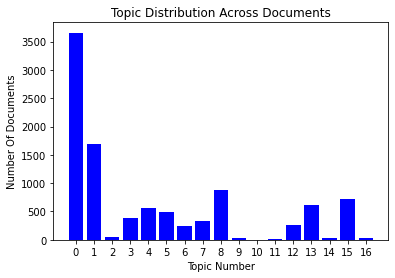

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(df_topic_distr['Topic Num'], df_topic_distr['Num Documents'], color='blue')
plt.xlabel("Topic Number")
plt.ylabel("Number Of Documents")
plt.title("Topic Distribution Across Documents")

plt.xticks(np.arange(0, 17))

plt.show()

In [ ]:
#The most representative sentence for each topic

topics_df_sorted = pd.DataFrame()
topics_df_groupby = topics_df.groupby('Dominant_Topic')

#print("topics_df_groupby : ", topics_df_groupby.head(10))
for i, grp in topics_df_groupby:
    topics_df_sorted = pd.concat([topics_df_sorted,grp.sort_values(['Percentage_Contribution'], 
                                  ascending=False).head(1)],axis=0)

# Reset Index    
topics_df_sorted.reset_index(drop=True, inplace=True)

# Format
topics_df_sorted.columns = ['Topic_Num', "Percentage_Contribution", "Keywords", "Representative Text"]

# Show
topics_df_sorted

,Topic_Num,Percentage_Contribution,Keywords,Representative Text
0,0,0.6300,"go, see, time, well, back, never, way, thing, ...","17 | 05-00 After a couple of re-sets, Sale wi..."
1,1,0.4818,"get, tory, pay, vote, s, stop, much, hear, car...",Never Carol is hitting the corrupt tories and ...
2,2,0.2589,"live, really, money, wale, spend, video, tweet...",Paedo who tortured and starved children with p...
3,3,0.3162,"make, still, love, try, bring, tell, book, fac...",Maybe we should make it “Glasgow Children’s Bo...
4,4,0.5323,"new, great, right, m, lot, maybe, home, cost, ...",Criterion certainly have US rights to the rest...
5,5,0.4952,"day, new_york, call, news, party, race, follow...",Horse Racing History: Today in Racing 4th Febr...
6,6,0.3496,"know, play, man, keep, family, woman, england,...",I’m watching a Polish movie 1930’s they would ...
7,7,0.4285,"look, watch, start, tomorrow, life, always, pa...",Chelsea vs Fulham - Live Stream Premier League...
8,8,0.3378,"year, work, support, also, find, read, full, a...","In my area, emergency services &amp; Thames Wa..."
9,9,0.3197,"conservative, show, week, today, racing, liste...",Click on the link below and listen to todays D...


In [ ]:
#Display Topic Number and Keywords

topics_df_sorted[['Topic_Num', 'Keywords']]

,Topic_Num,Keywords
0,0,"go, see, time, well, back, never, way, thing, ..."
1,1,"get, tory, pay, vote, s, stop, much, hear, car..."
2,2,"live, really, money, wale, spend, video, tweet..."
3,3,"make, still, love, try, bring, tell, book, fac..."
4,4,"new, great, right, m, lot, maybe, home, cost, ..."
5,5,"day, new_york, call, news, party, race, follow..."
6,6,"know, play, man, keep, family, woman, england,..."
7,7,"look, watch, start, tomorrow, life, always, pa..."
8,8,"year, work, support, also, find, read, full, a..."
9,9,"conservative, show, week, today, racing, liste..."


In [ ]:
#Wordcloud for Each topic

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

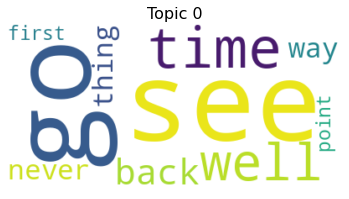

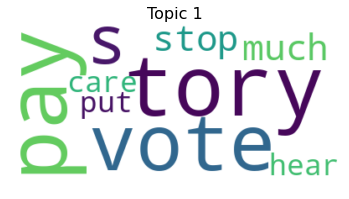

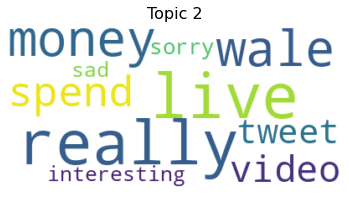

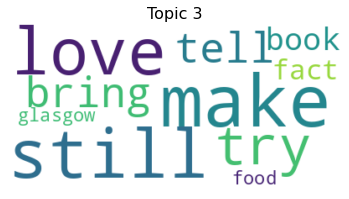

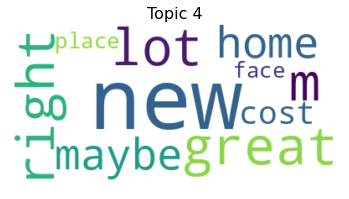

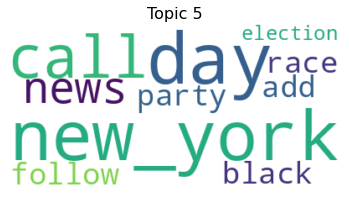

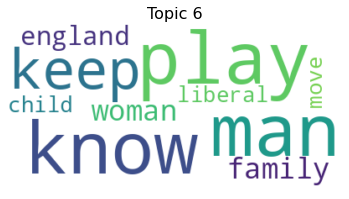

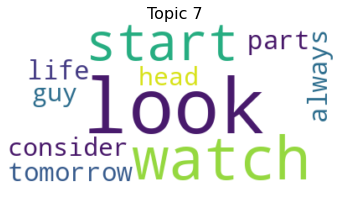

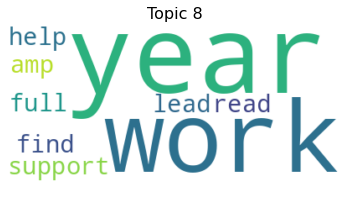

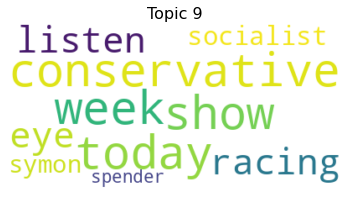

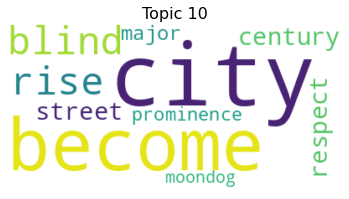

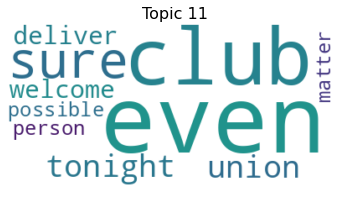

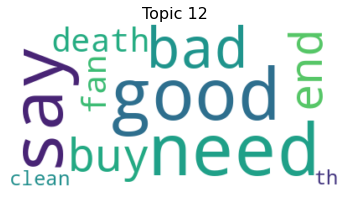

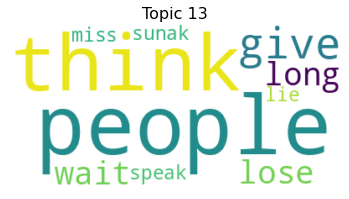

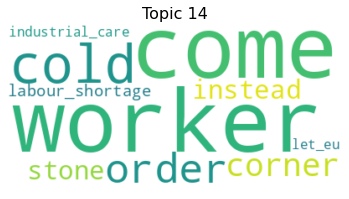

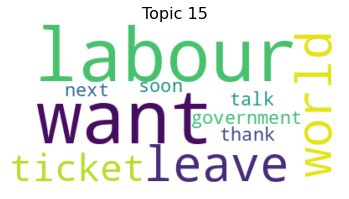

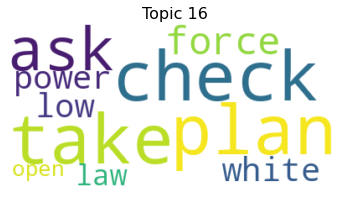

In [ ]:
#Wordcloud for Each topic 

#Word Cloud
for i in range(17):
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(topics_df_sorted['Keywords'][i])
    plt.imshow(word_cloud, interpolation='bilinear')
    topic_number = 'Topic ' + str(i)
    plt.title(topic_number, fontdict=dict(size=16))
    plt.axis("off")
    plt.show()


In [ ]:
# Visualize the topics using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.307812 -0.239160       1        1  12.027553
1     -0.219546  0.317420       2        1  11.929965
8     -0.026611  0.002724       3        1   8.605450
13    -0.000962 -0.001472       4        1   7.744261
15    -0.004611 -0.000960       5        1   7.729070
4      0.019084 -0.004183       6        1   7.152311
5      0.023740 -0.004731       7        1   6.848254
3      0.031771 -0.005496       8        1   6.257652
7      0.038594 -0.006231       9        1   5.642569
12     0.040830 -0.006368      10        1   5.621358
6      0.043949 -0.006679      11        1   5.486379
16     0.057131 -0.007606      12        1   3.518123
2      0.057842 -0.007647      13        1   3.478524
9      0.058842 -0.007637      14        1   3.202152
11     0.061302 -0.007724      15        1   2.649370
14     0.063413 -0.007391      16        1   1.662031
10     0.063043 -0.006857      17        1   0.444977, topic_info=           Term         Freq        Total Category  logprob  loglift
79           go  1482.000000  1482.000000  Default  30.0000  30.0000
147         get  1348.000000  1348.000000  Default  29.0000  29.0000
346         see  1280.000000  1280.000000  Default  28.0000  28.0000
382      people  1004.000000  1004.000000  Default  27.0000  27.0000
247        good   849.000000   849.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
3243       rise     0.025075     1.935100  Topic17  -9.6416   1.0689
2578       band     0.025025     1.931131  Topic17  -9.6436   1.0689
3295  yesterday     0.025026     1.932863  Topic17  -9.6436   1.0680
1986       wake     0.025019     1.931776  Topic17  -9.6438   1.0683
4707    british     0.025022     1.935627  Topic17  -9.6437   1.0665

[671 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
130       8  0.980592  absolutely
355      12  0.927365      access
192      15  0.934411      accord
210       6  0.974749     account
331      15  0.897687     achieve
...     ...       ...         ...
183      16  0.959535      worker
305       5  0.995363       world
580       7  0.979831       write
46        3  0.996611        year
568       2  0.988065         yet

[359 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 9, 14, 16, 5, 6, 4, 8, 13, 7, 17, 3, 10, 12, 15, 11])

In [3]:
from IPython.core.display import HTML
display(HTML('lda_result.html'))

### Grouped Tweets Processing

In [ ]:
#Import the dataset containing Grouped Tweets

# Import Dataset
df_grp = pd.read_csv('groupedTweets.csv')
df_grp.head()

,group,tweetID,username,text,qScore,nScore
0,0,1621600585291014145,realJackEason,@pansexualflower Criterion certainly have US r...,0.613271,2.934114
1,0,1621600597127331842,battez,@StratAnalytica @EconguyRosie yeah I'm in UK j...,0.603617,1.712620
2,0,1621600609030782981,Reno_station,@NappaBald66 Dry clean eraser should do the tr...,0.669598,3.165340
3,0,1621600638256693252,pedrinho_uk,@alanvibe @DrHoenderkamp @haringeycouncil @mik...,0.543737,3.485828
4,0,1621600792812609541,ClimateSchmidt,"@PGDynes Climate change is a real problem, but...",0.609599,1.870719


In [ ]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9968 entries, 0 to 9967
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   group     9968 non-null   int64  
 1   tweetID   9968 non-null   int64  
 2   username  9968 non-null   object 
 3   text      9968 non-null   object 
 4   qScore    9968 non-null   float64
 5   nScore    9968 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 467.4+ KB


In [ ]:
df_grp['username'].nunique()

7998

In [ ]:
df_grp['group'].nunique()

471

In [ ]:
df_grp.describe()

,group,tweetID,qScore,nScore
count,9968.000000,9.968000e+03,9968.000000,9968.000000
mean,85.552769,1.621603e+18,0.596870,0.608089
std,92.975854,1.578024e+12,0.055180,1.732554
min,0.000000,1.621601e+18,0.374306,-7.033362
25%,16.000000,1.621602e+18,0.571552,0.000000
50%,48.000000,1.621603e+18,0.607887,0.079807
75%,119.000000,1.621605e+18,0.609435,1.870719
max,470.000000,1.621606e+18,0.820619,5.259908


In [ ]:
#Merge the texts of individual tweets based on group id to fomr large text documents.

df_grp1 = df_grp.groupby(['group'])['text'].apply(', '.join).reset_index()


In [ ]:
df_grp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   group   471 non-null    int64 
 1   text    471 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.5+ KB


In [ ]:
df_grp1.iloc[0]['text']

'@pansexualflower Criterion certainly have US rights to the restoration but very unlikely they have any claim to UK UHD rights alone. This seems more like a cost analysis decision by the BFI. Or else they determined the new restoration doesn\'t merit 4K for home release, which would be odd., @StratAnalytica @EconguyRosie yeah I\'m in UK just realised this "context" and it all seems a bit sus now. maybe an accounting fudge from prev month to create this month. Hopefully someone qualified will look into it!, @NappaBald66 Dry clean eraser should do the trick as doesn\'t look to bad. Crumbly for heavier stains/jean bleed etc pal., @alanvibe @DrHoenderkamp @haringeycouncil @mikehakata @Togetherdec In my area, emergency services &amp; Thames Water had problems accessing roads because or roadblock LTN. Seems to also be a problem in some other locations. \n\nhttps://t.co/yae7RB7tRc, @PGDynes Climate change is a real problem, but the claim that Earth will be "uninhabitable" soon does not accura

In [ ]:
#Calculate Maximum and Minimum Length Tweets 

df_grp1['text_len'] = df_grp1['text'].str.len()
df_grp1_sorted = df_grp1.sort_values(by='text_len', ascending=False)

print(df_grp1_sorted[['text', 'text_len']].head())


print(df_grp1_sorted[['text', 'text_len']].tail())

                                                 text  text_len
15  George Santos – news: Secret tapes catch congr...    153533
14  Sounds like @dundeeunitedfc should consider ap...     71278
3   Excess Deaths Skyrocket Again In England And W...     54744
22  Paedo who tortured and starved children with p...     54228
26  @chris_London2 @JohnRealSmith Shocking left wi...     49640
                                     text  text_len
440  Keep fighting the authoritarian cult        36
436  @TheCardanoGame Research UK ETFs 🙈🙉🙊        36
413     Our extremely competent pilot ❤️🥰        33
453       26’ Darvel equalise (1-1) #U20s        31
420       99p Ruddles in Spoons 👍🇬🇧👍🇬🇧👍🇬🇧        31


In [ ]:
#Regular expression to remove email id and hyperlinks

# Convert to list
data_1 = df_grp1['text'].tolist()

# Remove Emails
data_1 = [re.sub('\S*@\S*\s?', '', sentence) for sentence in data_1]

# Remove new line characters
data_1 = [re.sub('\s+', ' ', sentence) for sentence in data_1]

# Remove distracting single quotes
data_1 = [re.sub("\'", "", sentence) for sentence in data_1]

#Remove Hyperlinks from the data
data_1 = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', sentence) for sentence in data_1]

#Remove Emojis from data
emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
data_1 = [re.sub(emoji, '', text) for text in data_1]

print(data_1[0])

Criterion certainly have US rights to the restoration but very unlikely they have any claim to UK UHD rights alone. This seems more like a cost analysis decision by the BFI. Or else they determined the new restoration doesnt merit 4K for home release, which would be odd., yeah Im in UK just realised this "context" and it all seems a bit sus now. maybe an accounting fudge from prev month to create this month. Hopefully someone qualified will look into it!, Dry clean eraser should do the trick as doesnt look to bad. Crumbly for heavier stains/jean bleed etc pal., In my area, emergency services &amp; Thames Water had problems accessing roads because or roadblock LTN. Seems to also be a problem in some other locations.  Climate change is a real problem, but the claim that Earth will be "uninhabitable" soon does not accurately represent the current state of scientific knowledge on the subject. Details matter, and even serious problems can be overstated.  My sister works FOH there Em! Look o

In [ ]:
#Tokenize the sentence and remove the punctuations

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  

data_words_1 = list(sent_to_words(data_1))

print(data_words_1[0])

['criterion', 'certainly', 'have', 'us', 'rights', 'to', 'the', 'restoration', 'but', 'very', 'unlikely', 'they', 'have', 'any', 'claim', 'to', 'uk', 'uhd', 'rights', 'alone', 'this', 'seems', 'more', 'like', 'cost', 'analysis', 'decision', 'by', 'the', 'bfi', 'or', 'else', 'they', 'determined', 'the', 'new', 'restoration', 'doesnt', 'merit', 'for', 'home', 'release', 'which', 'would', 'be', 'odd', 'yeah', 'im', 'in', 'uk', 'just', 'realised', 'this', 'context', 'and', 'it', 'all', 'seems', 'bit', 'sus', 'now', 'maybe', 'an', 'accounting', 'fudge', 'from', 'prev', 'month', 'to', 'create', 'this', 'month', 'hopefully', 'someone', 'qualified', 'will', 'look', 'into', 'it', 'dry', 'clean', 'eraser', 'should', 'do', 'the', 'trick', 'as', 'doesnt', 'look', 'to', 'bad', 'crumbly', 'for', 'heavier', 'stains', 'jean', 'bleed', 'etc', 'pal', 'in', 'my', 'area', 'emergency', 'services', 'amp', 'thames', 'water', 'had', 'problems', 'accessing', 'roads', 'because', 'or', 'roadblock', 'ltn', 'seems

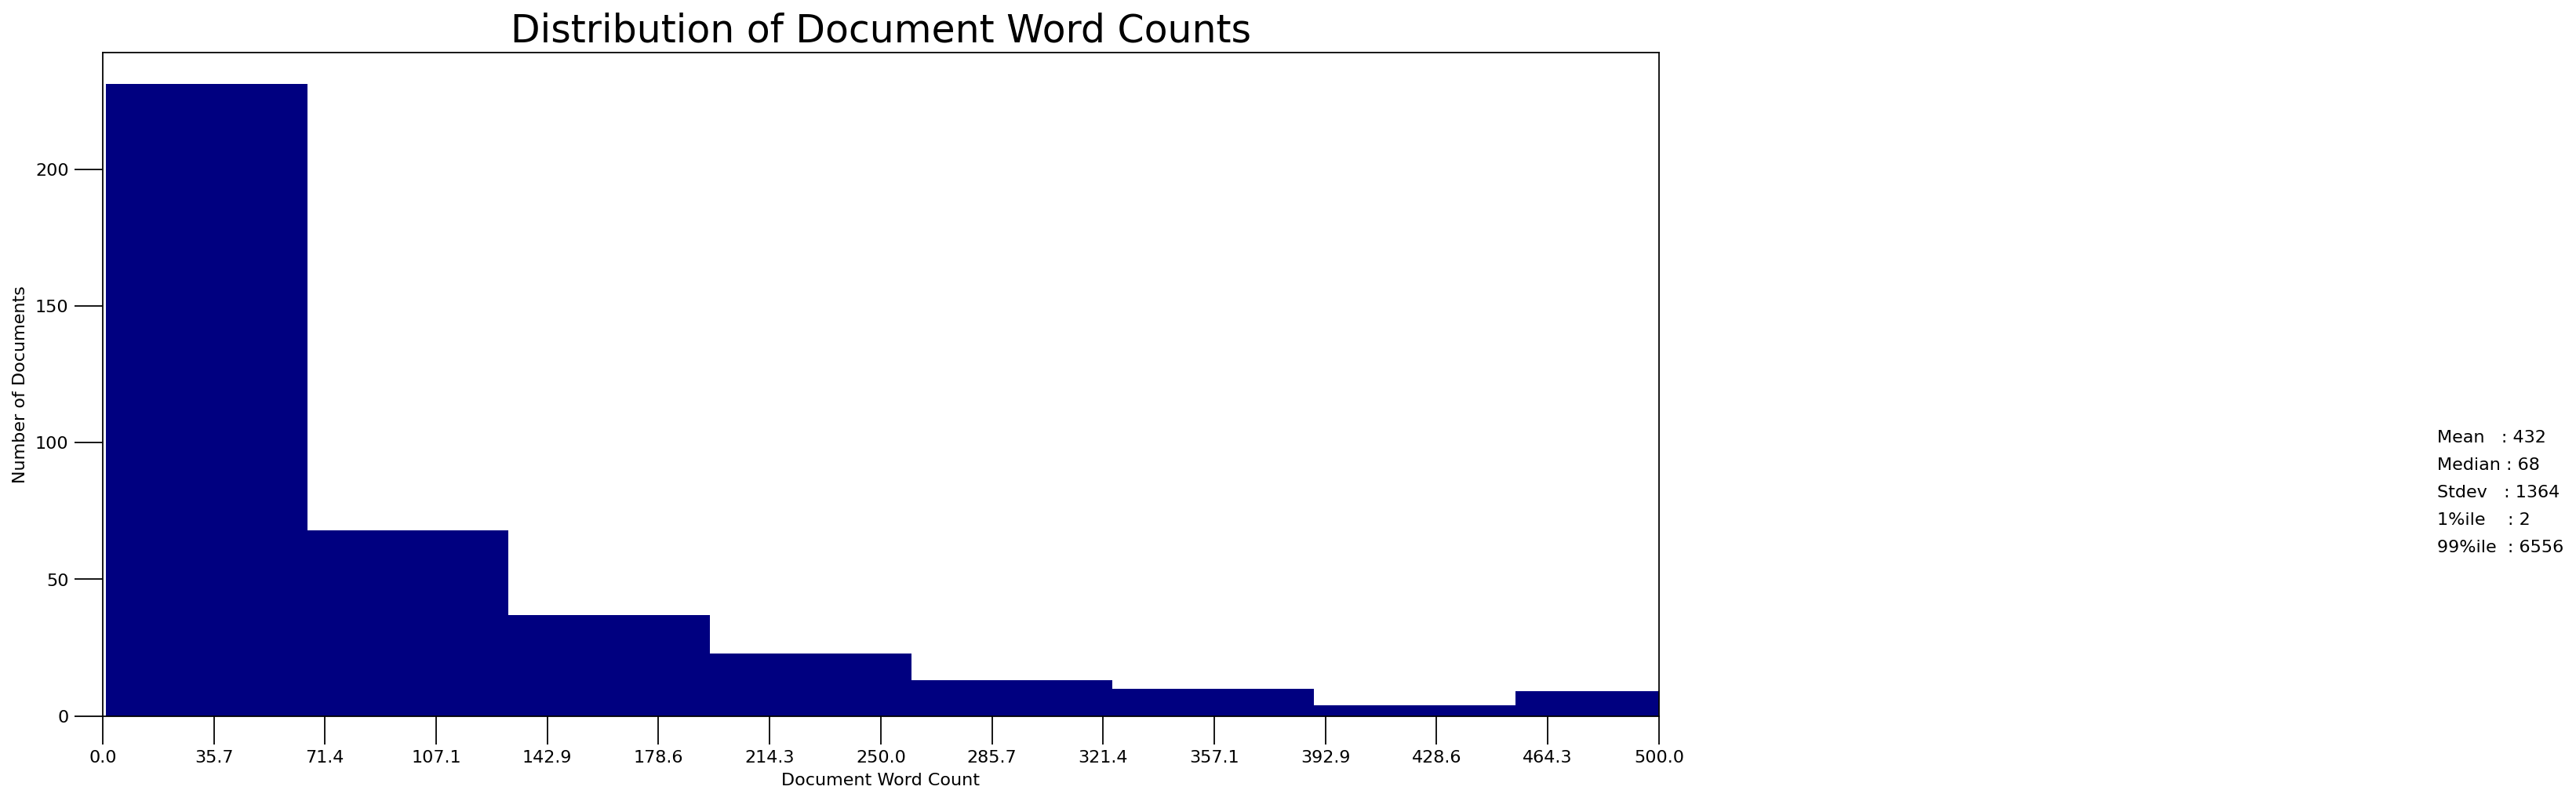

In [ ]:
#Distribution of Document word count ---> check how to do this

doc_word_distribution = [len(d) for d in data_words_1]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_word_distribution, bins = 300, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_word_distribution))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_word_distribution))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_word_distribution))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_word_distribution, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_word_distribution, q=0.99))))

plt.gca().set(xlim=(0, 500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,500,15))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()


In [ ]:
# Build the bigram
bigram = gensim.models.Phrases(data_words_1, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)


In [ ]:
# Remove stopwords and make Bigrams

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
stop_words = stopwords.words('english')
data_words_nostops_1 = remove_stopwords(data_words_1)

# Form Bigrams
data_words_bigrams_1 = make_bigrams(data_words_nostops_1)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
import spacy
nlp = spacy.load("en_core_web_sm")
print(nlp)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_1 = lemmatization(data_words_bigrams_1, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized_1[0])

['criterion', 'certainly', 'right', 'restoration', 'unlikely', 'claim', 'right', 'alone', 'seem', 'cost', 'analysis', 'decision', 'bfi', 'else', 'determine', 'new', 'restoration', 'merit', 'home', 'release', 'odd', 'm', 'realise', 'context', 'seem', 'bit', 'sus', 'maybe', 'account', 'fudge', 'prev', 'month', 'create', 'month', 'hopefully', 'qualified', 'look', 'dry', 'clean', 'eraser', 'trick', 'look', 'bad', 'crumbly', 'heavy', 'stain', 'area', 'thame', 'water', 'problem', 'access', 'road', 'seem', 'also', 'problem', 'location', 'climate_change', 'real', 'problem', 'claim', 'earth', 'uninhabitable', 'soon', 'accurately', 'represent', 'current', 'state', 'scientific', 'knowledge', 'subject', 'detail', 'matter', 'even', 'serious', 'problem', 'overstate', 'sister', 'work', 'look', 'honestly', 'precious', 'omg', 'look', 'seem', 'relevant', 'dorrie', 'miss', 'look', 'pig', 'fly', 'say', 'sunak', 'wish', 'peace', 'health', 'people', 'hon', 'lovely', 'respond', 'please', 'give', 'visa', 'res

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized_1)

# Create Corpus
texts = data_lemmatized_1

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 3), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 4), (105, 3), (106, 1), (107, 3), (108, 2), (109, 1), (110, 1),

In [ ]:
#Term frequency of words in corpus

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('absolute', 1),
  ('access', 1),
  ('account', 1),
  ('accurately', 1),
  ('achieve', 1),
  ('adaptation', 2),
  ('aged', 1),
  ('ago', 1),
  ('alone', 1),
  ('also', 1),
  ('amp', 2),
  ('analysis', 3),
  ('analyst', 1),
  ('angel', 1),
  ('anywhere', 1),
  ('apprentice', 1),
  ('appropriate', 1),
  ('area', 2),
  ('arena', 2),
  ('artist', 1),
  ('assessment', 1),
  ('avoid', 1),
  ('bad', 1),
  ('batch', 1),
  ('beautiful', 1),
  ('bfi', 1),
  ('bhp', 1),
  ('bias', 1),
  ('biblical', 1),
  ('bit', 1),
  ('brian', 2),
  ('bring', 1),
  ('british', 1),
  ('bronze', 1),
  ('call', 1),
  ('card', 1),
  ('care', 1),
  ('carr', 1),
  ('cat', 1),
  ('certain', 1),
  ('certainly', 1),
  ('citizen', 1),
  ('claim', 2),
  ('clean', 1),
  ('climate_change', 1),
  ('club', 1),
  ('complaint', 1),
  ('confirm', 1),
  ('congratulation', 1),
  ('context', 1),
  ('controversial', 1),
  ('cost', 1),
  ('course', 1),
  ('cover', 2),
  ('create', 1),
  ('criterion', 1),
  ('crumbly', 1),
  ('cup',

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.023*"man" + 0.016*"rest" + 0.014*"lab" + 0.013*"produce" + 0.013*"serve" + 0.013*"cyberpunk_dystopia" + 0.013*"antiwork_horror" + 0.013*"longer_born" + 0.013*"story_set" + 0.013*"humanity_tom"'), (1, '0.026*"see" + 0.017*"love" + 0.015*"worker" + 0.009*"come" + 0.008*"free" + 0.006*"labour_shortage" + 0.006*"corner" + 0.006*"similar_culture" + 0.006*"retail_builde" + 0.006*"hospitality_agriculture"'), (2, '0.021*"people" + 0.016*"well" + 0.013*"great" + 0.010*"game" + 0.007*"really" + 0.005*"see" + 0.005*"go" + 0.005*"read" + 0.005*"good" + 0.004*"mate"'), (3, '0.010*"get" + 0.009*"go" + 0.007*"say" + 0.007*"make" + 0.005*"think" + 0.005*"work" + 0.005*"know" + 0.005*"good" + 0.005*"want" + 0.005*"labour"'), (4, '0.016*"link" + 0.008*"flight" + 0.008*"flight_callsign" + 0.007*"pmqs_question" + 0.007*"michellemone_fraud" + 0.007*"petition" + 0.006*"need_enoughisenough" + 0.006*"use" + 0.005*"land" + 0.005*"able"'), (5, '0.004*"fashion" + 0.003*"tuning_race" + 0.003*"cadeau_sport

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized_1, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




Perplexity:  -8.4807977855914

Coherence Score:  0.42934640439198707


In [ ]:
#Hyperparameter Tuning 

#1. Number of Topics (K)
#2. Dirichlet hyperparameter alpha: Document-Topic Density
#3. Dirichlet hyperparameter beta: Word-Topic Density

In [ ]:
### Define the function

def compute_coherence_perplexity_values(dictionary, corpus, texts, num_topics=20):
    coherence_values = []
    perplexity_values = []
       
    model_list = []
    for num_of_topics in range(5,num_topics,1):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(lda_model.log_perplexity(corpus))
          
    return model_list, coherence_values, perplexity_values


In [ ]:
# Can take a long time to run.
model_list, coherence_values, perplexity_values = compute_coherence_perplexity_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized_1, num_topics=25)

In [ ]:
n = np.arange(5,25)
dict_coherence_perplexity_1 = {'Num_Topics':n, "Coherence_Score": coherence_values, "Perplexity_Score": perplexity_values}
#print(dict_coherence_perplexity)
df_coherence_perplexity_1 = pd.DataFrame(dict_coherence_perplexity_1)
print(df_coherence_perplexity_1)

    Num_Topics  Coherence_Score  Perplexity_Score
0            5         0.368873         -8.266753
1            6         0.338660         -8.264937
2            7         0.388732         -8.273274
3            8         0.359323         -8.318699
4            9         0.410375         -8.397743
5           10         0.429346         -8.480798
6           11         0.424665         -8.756180
7           12         0.444813         -8.927883
8           13         0.470763         -9.100759
9           14         0.473525         -9.287629
10          15         0.415809         -9.456750
11          16         0.477105         -9.635033
12          17         0.463854         -9.816552
13          18         0.407180        -10.056252
14          19         0.458238        -10.199394
15          20         0.392132        -10.361721
16          21         0.417733        -10.539330
17          22         0.487595        -10.695662
18          23         0.443278        -10.842751


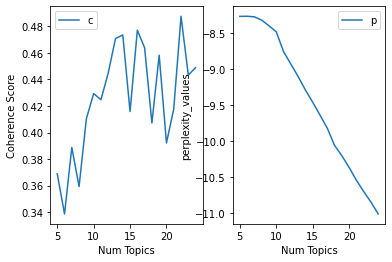

In [ ]:
# Plot Graph of Number of Topics vs Coherence Score
limit=25; start=5; step=1;
plt.subplot(1, 2, 1)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence"), loc='best')
#plt.show()


# Plot Graph of Number of Topics vs Perplexity Score
limit=25; start=5; step=1;
plt.subplot(1, 2, 2)
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("perplexity_values")
plt.legend(("perplexity"), loc='best')
plt.show()



In [ ]:
# Select the Best model 

optimal_model_1 =  model_list[11]
print(optimal_model_1)
model_topics = optimal_model_1.show_topics(formatted=False)

# Compute Perplexity
print('\nPerplexity: ', optimal_model_1.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model_1, texts=data_lemmatized_1, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




LdaModel(num_terms=12613, num_topics=16, decay=0.5, chunksize=100)

Perplexity:  -9.635033177182338

Coherence Score:  0.4771051961955878


In [ ]:
print("Top 10 Keywords in the Topics:")
pprint(optimal_model_1.print_topics(num_words=10))

Top 10 Keywords in the Topics:
[(0,
  '0.028*"rest" + 0.024*"lab" + 0.024*"produce" + 0.023*"serve" + '
  '0.023*"cyberpunk_dystopia" + 0.023*"antiwork_horror" + 0.023*"humanity_tom" '
  '+ 0.023*"story_set" + 0.023*"longer_born" + 0.023*"man"'),
 (1,
  '0.026*"love" + 0.013*"see" + 0.013*"free" + 0.007*"know" + 0.006*"reason" + '
  '0.005*"irgc" + 0.005*"hilarious" + 0.005*"arm" + 0.005*"valentine" + '
  '0.004*"environmental"'),
 (2,
  '0.023*"well" + 0.019*"day" + 0.017*"game" + 0.009*"see" + 0.009*"find" + '
  '0.008*"go" + 0.008*"available" + 0.008*"night" + 0.008*"fan" + '
  '0.008*"video"'),
 (3,
  '0.011*"get" + 0.010*"go" + 0.009*"say" + 0.008*"make" + 0.007*"think" + '
  '0.006*"year" + 0.006*"back" + 0.005*"still" + 0.005*"live" + 0.005*"come"'),
 (4,
  '0.006*"top" + 0.003*"telegraph" + 0.002*"permission" + 0.002*"transplant" + '
  '0.002*"automatic" + 0.002*"giveaway" + 0.002*"adaptation" + '
  '0.002*"condensation" + 0.002*"fertility" + 0.002*"hon"'),
 (5,
  '0.004*"castl

In [ ]:
### find the dominant Topic and its contribution in the corpus

def find_topic_in_document(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        if ldamodel.per_word_topics:
          row = row_list[0]
        else :
         row = row_list            
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_number, topic_perc_contribution) in enumerate(row):
            if j == 0: 
                w = ldamodel.show_topic(topic_number)
                #print("W : ", w)
                topic_keywords = ", ".join([word for word, word_per_contribution in w])
                topics_df = topics_df.append(pd.Series([int(topic_number), round(topic_perc_contribution,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Topic', 'Percentage_Contribution', 'Keywords']

    original_text = pd.DataFrame(texts)
    topics_df = pd.concat([topics_df, original_text], axis=1)
    return(topics_df)


In [ ]:
topics_df_1 = find_topic_in_document(ldamodel=optimal_model_1, corpus=corpus, texts=data_1)


In [ ]:
# Format
df_dominant_topic_1 = topics_df_1.reset_index()
df_dominant_topic_1.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_1.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.6339,"get, go, say, make, think, year, back, still, ...",Criterion certainly have US rights to the rest...
1,1,3,0.6132,"get, go, say, make, think, year, back, still, ...",#China #Chinese #Foreign #Ministry said that...
2,2,3,0.4651,"get, go, say, make, think, year, back, still, ...",“As they began to understand the children’s op...
3,3,3,0.7349,"get, go, say, make, think, year, back, still, ...",Excess Deaths Skyrocket Again In England And W...
4,4,10,0.9016,"worker, come, corner, posted_photo, retail_bui...","scotland, seychelles, syria, south africa, sou..."
5,5,3,0.6305,"get, go, say, make, think, year, back, still, ...",Horse Racing History: Today in Racing 4th Febr...
6,6,3,0.9127,"get, go, say, make, think, year, back, still, ...",ridiculous service from your store. Remembered...
7,7,3,0.8212,"get, go, say, make, think, year, back, still, ...",Check out Snake Eyes DVD (2021) #eBay via Che...
8,8,3,0.5448,"get, go, say, make, think, year, back, still, ...",de Jouvenels Sovereignty (1957) has a fable ab...
9,9,3,0.6436,"get, go, say, make, think, year, back, still, ...","They break the law with impunity, and have no ..."


In [ ]:
#Topic distribution across documents 

df_topic_distr_1 = df_dominant_topic_1['Dominant_Topic'].value_counts().reset_index(name="Num Of Documents")
df_topic_distr_1.columns = ['Topic Num', 'Num Documents']
df_topic_distr_1

,Topic Num,Num Documents
0,3,310
1,14,93
2,2,30
3,6,8
4,7,7
5,1,6
6,10,5
7,11,3
8,12,3
9,8,2


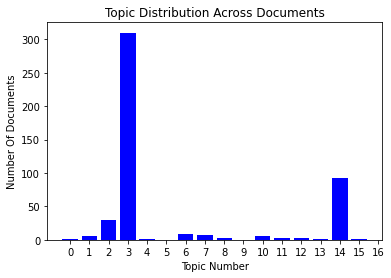

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(df_topic_distr_1['Topic Num'], df_topic_distr_1['Num Documents'], color='blue')
plt.xlabel("Topic Number")
plt.ylabel("Number Of Documents")
plt.title("Topic Distribution Across Documents")

plt.xticks(np.arange(0, 17))

plt.show()

In [ ]:
#The most representative sentence for each topic

topics_df_sorted_1 = pd.DataFrame()
topics_df_groupby_1 = topics_df_1.groupby('Dominant_Topic')

#print("topics_df_groupby : ", topics_df_groupby.head(10))
for i, grp in topics_df_groupby_1:
    topics_df_sorted_1 = pd.concat([topics_df_sorted_1,grp.sort_values(['Percentage_Contribution'], 
                                  ascending=False).head(1)],axis=0)

# Reset Index    
topics_df_sorted_1.reset_index(drop=True, inplace=True)

# Format
topics_df_sorted_1.columns = ['Topic_Num', "Percentage_Contribution", "Keywords", "Representative Text"]

# Show
topics_df_sorted_1

,Topic_Num,Percentage_Contribution,Keywords,Representative Text
0,0,0.8469,"rest, lab, produce, serve, cyberpunk_dystopia,...",But the rest of us wanting pay rise are greedy...
1,1,0.6516,"love, see, free, know, reason, irgc, hilarious...",Would you mind explaining the reason for this ...
2,2,0.8374,"well, day, game, see, find, go, available, nig...","Paco Rabanne, maverick fashion designer, dies ..."
3,3,0.9873,"get, go, say, make, think, year, back, still, ...","perhaps that they prefer go to Kabul?, Oh dear..."
4,4,0.4114,"top, telegraph, permission, transplant, automa...",#Binance #BNB #BNBChain #1000x #1000xgem #NFT ...
5,6,0.7338,"new, new_york, link_date, city, list, livestre...",Defendant - Stephen Edward Wells - had tried t...
6,7,0.6893,"amazing, month, air, fund, laugh, toxic, civil...",Piers Morgan’s 4 most controversial Uncensored...
7,8,0.6393,"ticket, sell, manchester_unite, manchester_uni...",I entered the Hamilton Lottery for £10 tickets...
8,10,0.9764,"worker, come, corner, posted_photo, retail_bui...",We Need a #GeneralElectionNow #EnoughIsEnough ...
9,11,0.8812,"link, flight, flight_callsign, use, able, land...","SUSSEX HAZE, 4.5%. Debuting from is this fruit..."


In [ ]:
#Display Topic Number and Keywords

topics_df_sorted_1[['Topic_Num', 'Keywords']]

,Topic_Num,Keywords
0,0,"rest, lab, produce, serve, cyberpunk_dystopia,..."
1,1,"love, see, free, know, reason, irgc, hilarious..."
2,2,"well, day, game, see, find, go, available, nig..."
3,3,"get, go, say, make, think, year, back, still, ..."
4,4,"top, telegraph, permission, transplant, automa..."
5,6,"new, new_york, link_date, city, list, livestre..."
6,7,"amazing, month, air, fund, laugh, toxic, civil..."
7,8,"ticket, sell, manchester_unite, manchester_uni..."
8,10,"worker, come, corner, posted_photo, retail_bui..."
9,11,"link, flight, flight_callsign, use, able, land..."


In [ ]:
#Wordcloud for Each topic

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

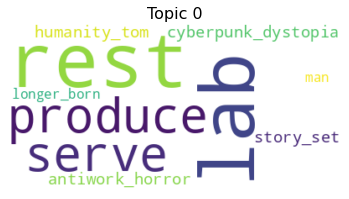

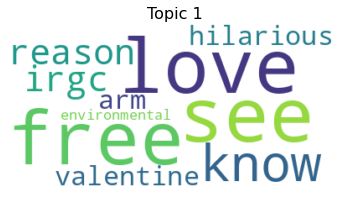

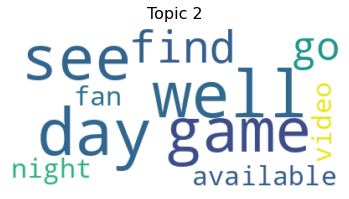

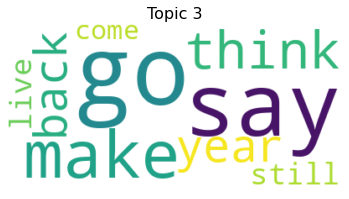

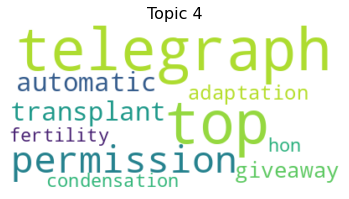

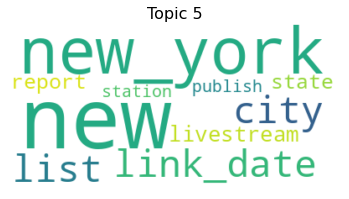

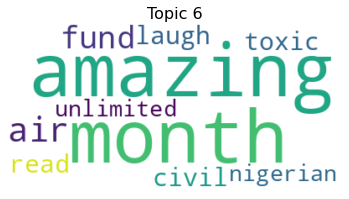

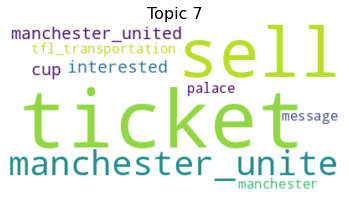

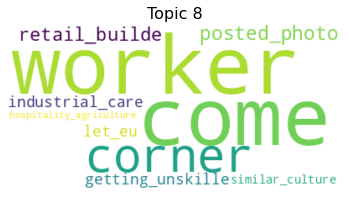

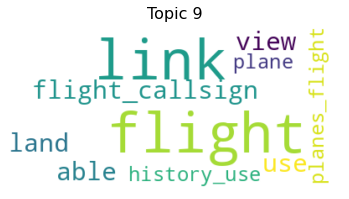

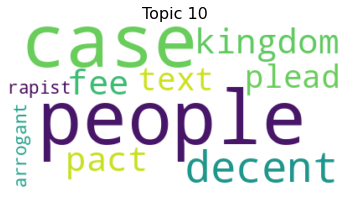

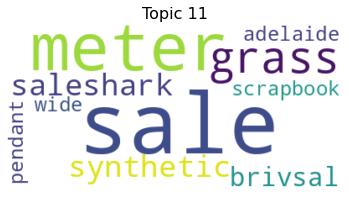

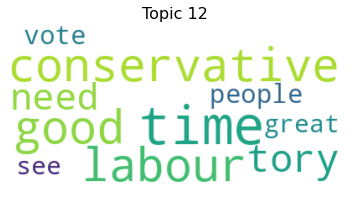

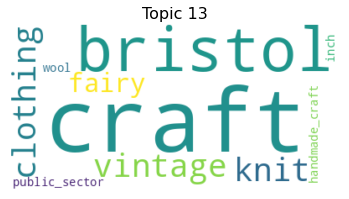

In [ ]:
#Wordcloud for Each topic 

#Word Cloud
for i in range(14):
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(topics_df_sorted_1['Keywords'][i])
    plt.imshow(word_cloud, interpolation='bilinear')
    topic_number = 'Topic ' + str(i)
    plt.title(topic_number, fontdict=dict(size=16))
    plt.axis("off")
    plt.show()


In [ ]:
# Visualize the topics using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model_1, corpus, id2word)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.334150  0.041605       1        1  52.120567
14    -0.320220  0.088141       2        1  29.018281
2     -0.144377 -0.252590       3        1   6.777599
6      0.034101  0.092992       4        1   3.694352
8      0.056607 -0.038921       5        1   1.748248
1      0.059222  0.002305       6        1   1.488409
7      0.073231  0.003163       7        1   1.125538
10     0.068500  0.012326       8        1   0.993366
0      0.078844  0.015490       9        1   0.952259
12     0.069117  0.013681      10        1   0.947601
11     0.064083  0.004352      11        1   0.621724
15     0.060658  0.003807      12        1   0.185152
4      0.061776  0.004351      13        1   0.158541
13     0.059859  0.002428      14        1   0.118104
9      0.056331  0.003505      15        1   0.026411
5      0.056417  0.003366      16        1   0.023847, topic_info=          Term        Freq       Total Category  logprob  loglift
182     people  349.000000  349.000000  Default  30.0000  30.0000
165        new  263.000000  263.000000  Default  29.0000  29.0000
155        man  233.000000  233.000000  Default  28.0000  28.0000
485       come  309.000000  309.000000  Default  27.0000  27.0000
805        use  215.000000  215.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
7245  strength    0.001604    0.778929  Topic16  -9.4514   2.1558
7940    wander    0.001604    0.778894  Topic16  -9.4514   2.1558
8234    ethnic    0.001604    0.778900  Topic16  -9.4514   2.1558
9103   mansion    0.001604    0.778894  Topic16  -9.4514   2.1558
9413   proceed    0.001604    0.778903  Topic16  -9.4514   2.1558

[786 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
407       1  0.568145      able
407       2  0.321125      able
407      11  0.123510      able
9300      6  0.721061  academic
4189      7  0.721488  accident
...     ...       ...       ...
828       1  0.862728      year
828       2  0.136700      year
830       1  0.963040       yet
830       2  0.027914       yet
1871      3  0.933572      zone

[916 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 15, 3, 7, 9, 2, 8, 11, 1, 13, 12, 16, 5, 14, 10, 6])

In [2]:
from IPython.core.display import HTML
display(HTML('lda_result_1.html'))